In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

In [2]:
conn = pyodbc.connect("DSN=HIVE_SIT", autocommit = True, ansi = True ) 
cur = conn.cursor()
cur.execute("use yarn_db")

In [3]:
# select the date range of data to be analysed
start_date= '2020-03-30'
end_date= '2020-04-10'

In [4]:
fetch_sql = "Select * From yarn_api_logs where ods between '{0}' and '{1}' ".format(start_date,end_date)
#print(fetch_sql)
df_out = pd.read_sql(fetch_sql,conn)

In [5]:
# typecast the fields
df_out['exec_mins']=df_out['exec_mins'].astype(float).round()
df_out['ods']=df_out['ods'].astype(datetime.date)
df_out['queue_usage_percent']=df_out['queue_usage_percent'].astype(float).round()
df_out['allocatedmb']=df_out['allocatedmb'].astype(int)
df_out['allocatedvcores']=df_out['allocatedvcores'].astype(int)

In [6]:
# Aggregating the execution minutes and checking mean and counts
df_total =df_out.groupby(['ods']).agg({'exec_mins':['mean'],'id':['count']})

In [7]:
df_total.columns = [ ' '.join(str(i) for i in col) for col in df_total.columns]
#df_total.reset_index(inplace=True)
df_total.head()

,exec_mins mean,id count
ods,,
2020-03-30,3.941176,34
2020-03-31,3.548387,31
2020-04-01,4.682540,63
2020-04-02,3.193277,119
2020-04-03,5.000000,149


In [8]:
df_out.queue_usage_percent.unique()

array([   0.,   60.,    1.,   14.,   13.,   90.,    7.,  128.,   62.,
        132.,   24.,   35.,  105.,   28.,   34.,   23.])

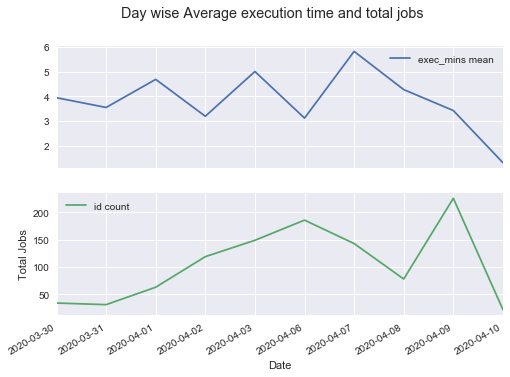

In [9]:
#fig = plt.figure(figsize=(12, 6))
df_total.plot.line(subplots=True, title='Day wise Average execution time and total jobs')
#plt.title('Day wise Average execution time and total jobs', fontsize=22)
plt.xlabel('Date')
plt.ylabel('Total Jobs')
plt.show()

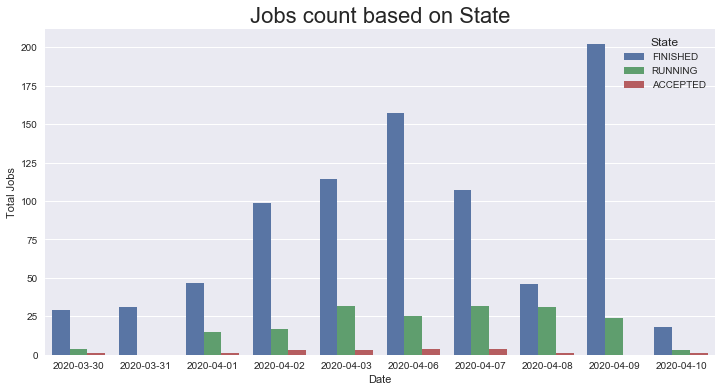

In [10]:
fig = plt.figure(figsize=(12, 6))
sns.countplot(x=df_out.ods, data=df_out,hue=df_out.state)
plt.title('Jobs count based on State', fontsize=22)
plt.xlabel('Date')
plt.ylabel('Total Jobs')
plt.legend(title='State', loc='upper right')
plt.show()

In [11]:
# creating a dataframe with only statistics of the data 
df_queue=df_out.where(df_out['state'] != 'FINISHED').dropna().groupby(['ods']).agg(['mean', 'max']).reset_index()
df_queue.columns = [ ' '.join(str(i) for i in col) for col in df_queue.columns]
df_queue.head()

,ods,exec_mins mean,exec_mins max,allocatedmb mean,allocatedmb max,allocatedvcores mean,allocatedvcores max,queue_usage_percent mean,queue_usage_percent max
0,2020-03-30,3.400000,12.0,16793.600000,56320.0,2.600000,7.0,17.800000,60.0
1,2020-04-01,6.375000,14.0,11072.000000,83968.0,2.062500,10.0,11.750000,90.0
2,2020-04-02,6.450000,31.0,4608.000000,56320.0,1.400000,7.0,4.850000,60.0
3,2020-04-03,8.828571,23.0,1989.485714,12288.0,1.085714,2.0,2.028571,13.0
4,2020-04-06,7.758621,57.0,12005.517241,119808.0,2.206897,15.0,12.896552,128.0


In [12]:
df_queue.dtypes

ods                          object
exec_mins mean              float64
exec_mins max               float64
allocatedmb mean            float64
allocatedmb max             float64
allocatedvcores mean        float64
allocatedvcores max         float64
queue_usage_percent mean    float64
queue_usage_percent max     float64
dtype: object

In [19]:
df_queue.rename(columns={"ods ": "ods"},inplace=True)


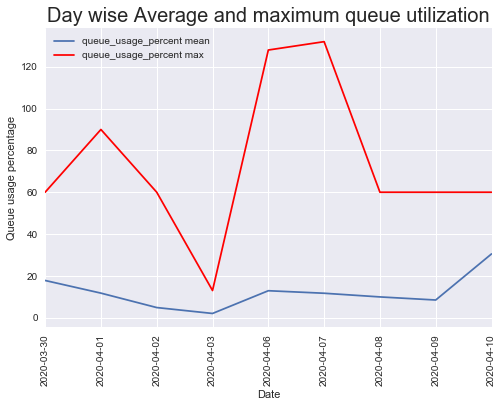

In [20]:

#fig = plt.figure(figsize=(14, 6))
ax = plt.gca()
df_queue.plot(kind='line', x='ods', y='queue_usage_percent mean',ax=ax)
df_queue.plot(kind='line', x='ods', y='queue_usage_percent max', color='red', ax=ax)

plt.title('Day wise Average and maximum queue utilization', fontsize=20)
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Queue usage percentage')
plt.show()

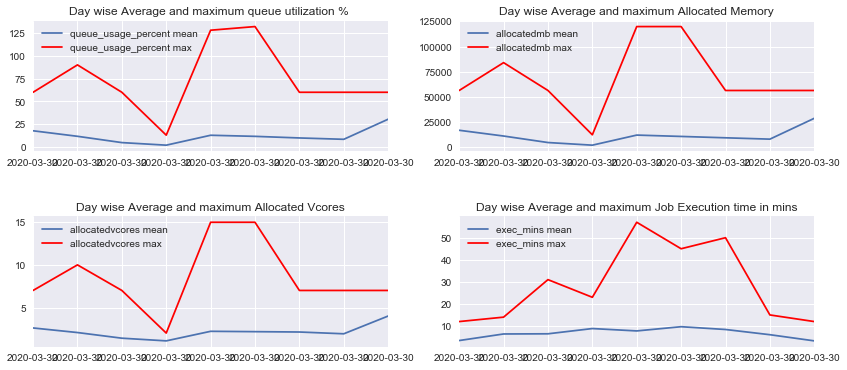

In [21]:
# plotting the graph to see how 4 paramters, alloacated memory, queue utilisation, allocated vcores, execution minutes are performing on each day
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
df_queue['ods']=df_out['ods'].astype(str)

#ax = plt.gca()
df_queue.plot(kind='line', x='ods', y='queue_usage_percent mean',ax=ax1)
df_queue.plot(kind='line', x='ods', y='queue_usage_percent max', color='red', ax=ax1)
ax1.xaxis.set_label_text("")
#ax1.tick_params(axis='x', tickdir=30)
ax1.set_title("Day wise Average and maximum queue utilization % ")

df_queue.plot(kind='line', x='ods', y='allocatedmb mean',ax=ax2)
df_queue.plot(kind='line', x='ods', y='allocatedmb max', color='red', ax=ax2)
ax2.xaxis.set_label_text("")
#plt.xticks(rotation=90)
ax2.set_title("Day wise Average and maximum Allocated Memory")

df_queue.plot(kind='line', x='ods', y='allocatedvcores mean',ax=ax3)
df_queue.plot(kind='line', x='ods', y='allocatedvcores max', color='red', ax=ax3)
ax3.xaxis.set_label_text("")
#ax3.xticks(rotation=90)
ax3.set_title("Day wise Average and maximum Allocated Vcores")

df_queue.plot(kind='line', x='ods', y='exec_mins mean',ax=ax4)
df_queue.plot(kind='line', x='ods', y='exec_mins max', color='red', ax=ax4)
ax4.xaxis.set_label_text("")
#ax4.xticks(rotation=90)
ax4.set_title("Day wise Average and maximum Job Execution time in mins")

#plt.title('Day wise Average and maximum queue utilization', fontsize=20)
#plt.xlabel('Date')
#plt.ylabel('Queue usage percentage')

fig.subplots_adjust(hspace=0.5)
plt.show()

In [22]:
df_day=df_out.loc[(df_out['ods'] == '2020-04-09') & (df_out['state'] != 'FINISHED'),['id','exec_mins','allocatedmb','allocatedvcores','queue_usage_percent']]
# exec_mins, allocatedmb, allocatedvcores, queue_usage_percent'
df_day_top = df_day.set_index('id').sort_values("queue_usage_percent", ascending=False).head(5)

# Plot the total crashes
#sns.set_color_codes("pastel")
#sns.barplot(x="total", y="abbrev", data=crashes, label="Total", color="b")
df_day_top

,exec_mins,allocatedmb,allocatedvcores,queue_usage_percent
id,,,,
application_1585877807528_449689,0.0,56320,7,60.0
application_1585877807528_446162,1.0,26624,6,28.0
application_1585877807528_446448,1.0,21504,5,23.0
application_1585877807528_446372,1.0,21504,3,23.0
application_1585877807528_446369,1.0,13312,2,14.0


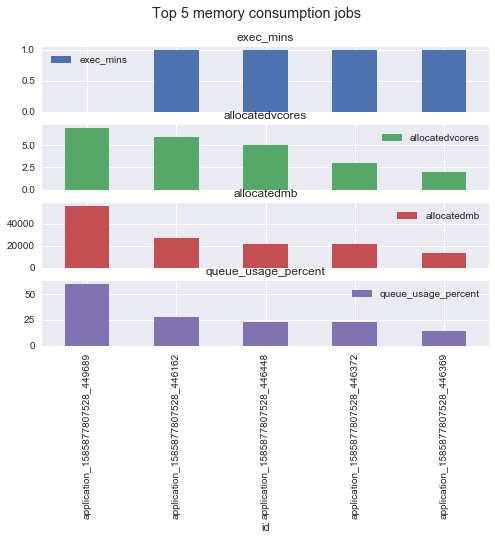

In [23]:
# Identifying the top 5 memory consuming jobs
fig = plt.figure(figsize=(10,10))
#labels = ['Execution Time in Mins', 'Allocated Memory in MB', 'Allocated Memory in Vcores', 'Queue Usage %']
ax = df_day_top[['exec_mins','allocatedvcores','allocatedmb','queue_usage_percent']].plot(kind='bar',subplots=True,
                                                 lw=2,title="Top 5 memory consumption jobs ",layout=(4,1))
#plt.title("Top 5 memory consumption jobs ")
#plt.xlabel("...",labelpad=4)
plt.show()


In [25]:
df_day.describe()

,exec_mins,allocatedmb,allocatedvcores,queue_usage_percent
count,24.000000,24.000000,24.000000,24.000000
mean,6.041667,7978.666667,1.916667,8.458333
std,4.666990,12935.005133,1.691839,13.787137
min,0.000000,1024.000000,1.000000,1.000000
25%,1.000000,1024.000000,1.000000,1.000000
50%,7.500000,1024.000000,1.000000,1.000000
75%,10.000000,12288.000000,2.000000,13.000000
max,15.000000,56320.000000,7.000000,60.000000


In [24]:
df_non_null=df_out[df_out['start_time'].notnull()].where(df_out['start_time'].str.len() > 4)
df_non_null['start_mins']=df_non_null['start_time'].str[11:16].replace(regex=':',value='.').astype(float)
#df_non_null.head()


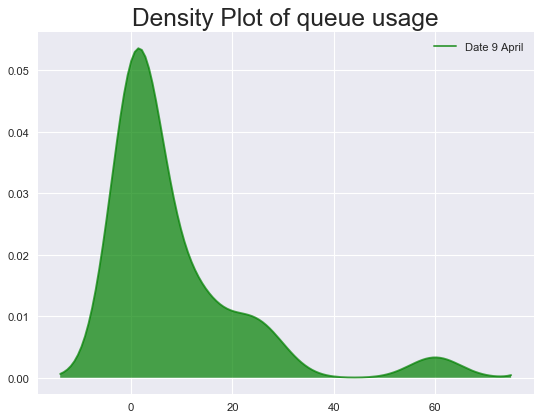

In [26]:
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(df_day.queue_usage_percent, shade=True, color="g", label="Date 9 April", alpha=.7)
plt.title('Density Plot of queue usage', fontsize=22)
plt.legend()
plt.show()

In [27]:
df_counts =df_non_null.groupby(['start_mins','ods']).size().reset_index(name='counts').dropna()
#df_counts.describe()

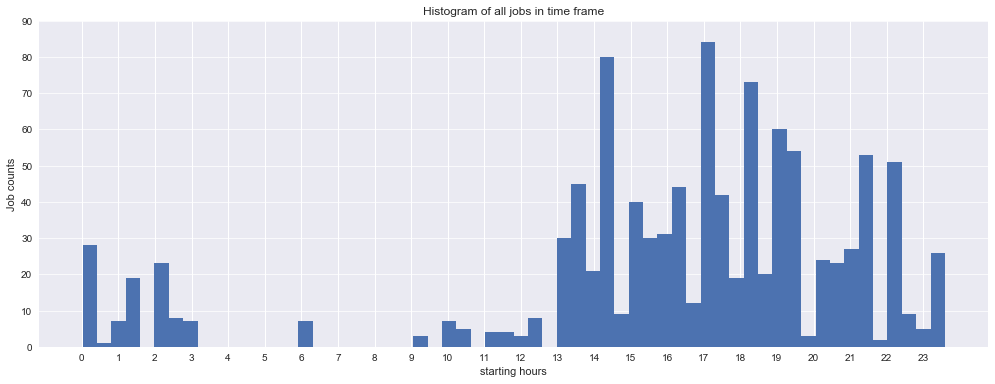

In [29]:
plt_data=df_non_null.start_mins
#plt_data.head()
fig = plt.figure(figsize=(17, 6))
n, bins, patches = plt.hist(x=plt_data, bins=60)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('starting hours')
plt.ylabel('Job counts')
plt.title('Histogram of all jobs in time frame')
maxfreq = n.max()
plt.xticks(range(0, 24))
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

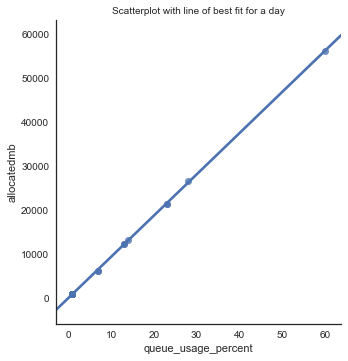

In [30]:
#df_queue_2=df_queue[['allocatedmb','queue_usage_percent']]
sns.set_style("white")
gridobj = sns.lmplot(x="queue_usage_percent", y="allocatedmb", data=df_day)

# Decorations
#gridobj.set(xlim=(0.5, 7.5), ylim=(0, 50))
plt.title("Scatterplot with line of best fit for a day", fontsize=10)
plt.show()

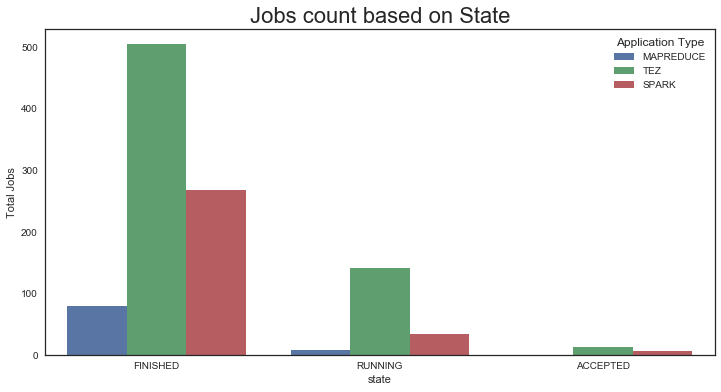

In [31]:
fig = plt.figure(figsize=(12, 6))
sns.countplot(x=df_out.state, data=df_out,hue=df_out.applicationtype)
plt.title('Jobs count based on State', fontsize=22)
plt.xlabel('state')
plt.ylabel('Total Jobs')
plt.legend(title='Application Type', loc='upper right')
plt.show()
